### Analyze_rotated_stable_points - evaluate bias in rotated DEMs using selected unchanged points

These points were picked on hopefully stable points in mostly flat places: docks, lawns, bare spots in middens. Also, the yurt roofs. Typically, 3 to 5 points were picked on most features. 

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define some functions
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az=np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))

    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [3]:
# coordinates for the whole-island box.
r = {'name':"ncorebx","e0": 378500.,"n0": 3856350.,"xlen": 36000.,"ylen": 1100.,"dxdy": 1.,"theta": 42.}

# Convert origin to UTM
xu,yu = box2UTMh(0.,0.,r['e0'],r['n0'],r['theta'])
print(xu,yu)

# reverse the calc to find the origin (UTM =0,0) in box coordinates.
# First, just do the rotation to see where Box = 0,0 falls
xb0,yb0 = box2UTMh(xu,yu,0.,0.,-r['theta'])
print(xb0,yb0)
# Then put in negative values for the offset
xb,yb = box2UTMh(xu,yu,-xb0,-yb0,-r['theta'])
print(xb,yb)

[378500.] [3856350.]
[2861682.13027518] [2612560.61322292]
[array([0.])] [array([0.])]


In [5]:
# Read in the list of stable points. Elevations were picked from the DEMs with Global Mapper. Elevations for Sep are from
# the old _crop version of the DEM.... .nc version read in below is from the newer _v3 version.
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\Santa_Cruz_Products\\stable_points\\All_points.csv",header = 0)

# convert UTM X, Y to rotated coords xrl, yrl
X = df["X"].values
Y = df["Y"].values
#TODO: why does this return a list of arrays?
xrl,yrl = box2UTMh(X,Y,-xb0,-yb0,-r['theta'])
# this fixes it...probably should fix box2UTMh
xrot = np.concatenate(xrl).ravel()
yrot = np.concatenate(yrl).ravel()

df["xr"] = xrot
df["yr"] = yrot

In [6]:
# read in the multi-map .nc file

# Dates for DEMs
dates = ([\
         "30 Aug 2019",\
         "13 Sep 2019",\
         "11 Oct 2019",\
         "26 Nov 2019"])

# Offsets for DEM elevation corrections
# These are the mean anomolies when this script is run with zero offsets
# Aug anom      0.022233
# Sep anom     -0.002373
# Oct anom     -0.004543
# Nov anom     -0.015317
# Medians
# Aug anom      0.011046
# Sep anom     -0.011883
# Oct anom     -0.010752
# Nov anom     -0.020816
# Std. dev
# Aug anom      0.052332
# Sep anom      0.059450
# Oct anom      0.050611
# Nov anom      0.069708

# Same values when the offset is applied
# Mean
# Aug anom      1.636533e-07
# Sep anom      4.703386e-08
# Oct anom      2.423299e-07
# Nov anom     -4.530171e-07
# Median
# Aug anom     -0.011187
# Sep anom     -0.009510
# Oct anom     -0.006209
# Nov anom     -0.005499
# Std dev
# Aug anom      0.052332
# Sep anom      0.059450
# Oct anom      0.050611
# Nov anom      0.069708

# ALERT - change this line to offset final results or not
offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317])
#offset = np.array([0., 0., 0., 0.])

fn = r['name']+'.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] + offset[i]    

nmaps, ncross, nalong:  4 1100 36000


In [7]:
# Use rotated coordinates as indices into the maps to get elevations.
ix = df["xr"].values.astype(np.int64)
iy = df["yr"].values.astype(np.int64)

zr = np.ones(len(ix))
for i in range(0, len(ix)):
    zr[i] = dsaa[0,iy[i],ix[i]].values
df["zr Aug"]=zr

zr = np.ones(len(ix))
for i in range(0, len(ix)):
    zr[i] = dsaa[1,iy[i],ix[i]].values
df["zr Sep"]=zr

zr = np.ones(len(ix))
for i in range(0, len(ix)):
    zr[i] = dsaa[2,iy[i],ix[i]].values
df["zr Oct"]=zr

zr = np.ones(len(ix))
for i in range(0, len(ix)):
    zr[i] = dsaa[3,iy[i],ix[i]].values
df["zr Nov"]=zr
df

,X,Y,lidar_gnd50,lidar all90,lidar_first50,Aug,Sep,Oct,Nov,xr,yr,zr Aug,zr Sep,zr Oct,zr Nov
0,387521.064,3864904.303,2.033,2.148,4.168,2.111,2.134,2.099,2.138,12427.902985,320.815986,1.992361,2.012552,2.027329,2.085333
1,387524.918,3864904.854,2.110,2.197,4.278,2.219,2.221,2.187,2.268,12431.135756,318.646629,2.175277,2.152285,2.175749,2.277763
2,387525.102,3864929.447,1.732,1.784,3.520,1.804,1.854,1.791,1.894,12447.728424,336.799670,1.782258,1.784474,1.801587,1.896311
3,387524.001,3864924.308,1.693,1.763,3.468,1.802,1.859,1.830,1.880,12443.471559,333.717361,1.772058,1.801418,1.822477,1.883030
4,387543.822,3864912.012,1.812,1.823,3.630,1.864,1.911,1.869,1.955,12449.973803,311.316815,1.847290,1.851877,1.878295,1.976670
5,387604.204,3864943.579,1.810,1.839,3.620,1.879,1.871,1.904,1.947,12515.968820,294.372223,1.846126,1.800537,1.890493,1.951980
6,387602.185,3864951.471,1.667,1.683,3.348,1.755,1.730,1.749,1.806,12519.749189,301.588097,1.743843,1.691732,1.754906,1.830838
7,387604.204,3864943.579,1.810,1.839,3.620,1.879,1.871,1.904,1.947,12515.968820,294.372223,1.846126,1.800537,1.890493,1.951980
8,390597.287,3868350.494,0.380,0.419,0.806,0.434,0.495,0.550,0.475,17019.934063,823.440034,0.416669,0.404337,0.605843,0.487117
9,390597.287,3868350.494,0.380,0.419,0.806,0.434,0.495,0.550,0.475,17019.934063,823.440034,0.416669,0.404337,0.605843,0.487117


In [9]:
# looks like three points are outside the domain. Drop them from the dataframe
dfc = df[df['zr Sep']>-10.].reset_index(drop=True)

# Calculate the average for each row for the four maps (don't average in the lidar)
col = dfc.loc[: , "zr Aug":"zr Nov"]
dfc['mean']=col.mean(axis=1)

# Calculate the anomoly for each point
dfc['gnd50 anom']=dfc['lidar_gnd50']-dfc['mean']
dfc['all90 anom']=dfc['lidar all90']-dfc['mean']
dfc['first50 anom']=dfc['lidar_first50']-dfc['mean']
dfc['Aug anom']=dfc['zr Aug']-dfc['mean']
dfc['Sep anom']=dfc['zr Sep']-dfc['mean']
dfc['Oct anom']=dfc['zr Oct']-dfc['mean']
dfc['Nov anom']=dfc['zr Nov']-dfc['mean']

In [11]:
df_anom = dfc.loc[:,"gnd50 anom":"Nov anom"].copy()

In [12]:
%run -i CoreBx_funcs
print(df_anom.mean())
print(df_anom.median())
print(df_anom.std())

stat_summary(df_anom['Aug anom'].values,iprint=True)
stat_summary(df_anom['Sep anom'].values,iprint=True)
stat_summary(df_anom['Oct anom'].values,iprint=True)
stat_summary(df_anom['Nov anom'].values,iprint=True)

gnd50 anom     -1.279436e-01
all90 anom     -4.996364e-02
first50 anom    1.387476e+00
Aug anom        1.636533e-07
Sep anom        4.703386e-08
Oct anom        2.423299e-07
Nov anom       -4.530171e-07
dtype: float64
gnd50 anom     -0.118025
all90 anom     -0.064360
first50 anom    1.371008
Aug anom       -0.011187
Sep anom       -0.009510
Oct anom       -0.006209
Nov anom       -0.005499
dtype: float64
gnd50 anom      0.066254
all90 anom      0.140018
first50 anom    0.662200
Aug anom        0.052332
Sep anom        0.059450
Oct anom        0.050611
Nov anom        0.069708
dtype: float64
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.052
min    = -0.109
max    = 0.123
d5     = -0.068
d25    = -0.035
d50    = -0.011
d75    = 0.029
d95    = 0.103
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.059
min    = -0.111
max    = 0.166
d5     = -0.074
d25    = -0.042
d50    = -0.010
d75    = 0.045
d95    = 0.093
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.050
m

{'n': 50,
 'nnan': 0,
 'mean': -4.5301705128508727e-07,
 'std': 0.06900702379004166,
 'min': -0.1173504128314653,
 'max': 0.2164959765147385,
 'd5': -0.0983888535995352,
 'd25': -0.05121664919455793,
 'd50': -0.005499113679110046,
 'd75': 0.03224896785031678,
 'd95': 0.08559765719414776}

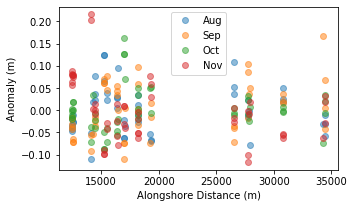

In [13]:
plt.figure(figsize=(5,3))
plt.plot(dfc['xr'],dfc['Aug anom'],'o',alpha=.5,label='Aug')
plt.plot(dfc['xr'],dfc['Sep anom'],'o',alpha=.5,label='Sep')
plt.plot(dfc['xr'],dfc['Oct anom'],'o',alpha=.5,label='Oct')
plt.plot(dfc['xr'],dfc['Nov anom'],'o',alpha=.5,label='Nov')
plt.legend()
plt.ylabel('Anomaly (m)')
plt.xlabel('Alongshore Distance (m)')
plt.savefig('unchanged_pts_along_anom_adjusted_dems.png',dpi=200,bbox_inches = 'tight')

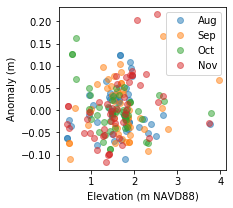

In [14]:
plt.figure(figsize=(3,3))
plt.plot(dfc['Aug'],dfc['Aug anom'],'o',alpha=.5,label='Aug')
plt.plot(dfc['Sep'],dfc['Sep anom'],'o',alpha=.5,label='Sep')
plt.plot(dfc['Oct'],dfc['Oct anom'],'o',alpha=.5,label='Oct')
plt.plot(dfc['Nov'],dfc['Nov anom'],'o',alpha=.5,label='Nov')
plt.legend()
plt.ylabel('Anomaly (m)')
plt.xlabel('Elevation (m NAVD88)')
plt.savefig('unchanged_pts_elev_anom_adjusted_dems.png',bbox_inches = 'tight',dpi=200)

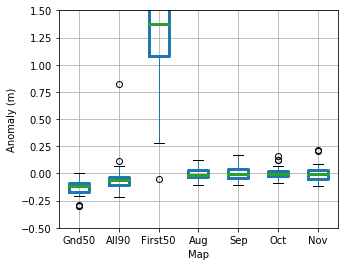

In [16]:
# boxplot of anomolies
fig, ax =plt.subplots(figsize=(5,4))
boxprops = dict(linestyle='-', linewidth=3, color='k')
medianprops = dict(linestyle='-', linewidth=3, color='k')
bp=df_anom.boxplot(figsize=(6,5),grid=True,boxprops=boxprops, medianprops=medianprops)
plt.ylabel('Difference from Four-Map Mean (m)')
plt.ylim((-0.5,1.5))
plt.ylabel('Anomaly (m)')
ax.set_xticklabels(["Gnd50","All90","First50","Aug","Sep","Oct","Nov"])
plt.xlabel('Map')
plt.savefig('unchanged_pts_boxplot_adjusted_dems.png',dpi=200,bbox_inches = 'tight')
#plt.savefig('offset_corrected_pts_boxplot_adjusted_dems.png',dpi=200,bbox_inches = 'tight')